# Intro

This notebook is an experimentation code for "Case study: a comparision of different consumer recommendation engines based on deep neural networks".

Paper is using [Amazon Reviews 2018 dataset](https://nijianmo.github.io/amazon/index.html)

Insiration notebook [can be found here](https://github.com/iritfh1/Next-item-recommendation-using-keras/blob/master/DeepRecommendation_LAST3.ipynb)


In [1]:
import pandas as pd
import os
import json
import gzip
import numpy as np
import tensorflow as tf
import tensorflow.keras as kk
import scipy.stats as st
import gc 
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold
from tqdm.auto import tqdm
from itertools import cycle, zip_longest

In [2]:
sns.set_style("whitegrid")

In [3]:
!pip install scikit-posthocs

In [3]:
import scikit_posthocs as sp

# Loading data

## 'All beauty' data

In [4]:
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/All_Beauty_5.json.gz

/bin/sh: wget: command not found


In [5]:
data_f = "All_Beauty_5.json.gz"

In [53]:
data = []
with gzip.open(data_f) as f:
    for l in f:
        data.append(json.loads(l.strip()))
    
# total length of list, this number equals total number of products
print(len(data))

# first row of the list
print(data[0])

5269
{'overall': 5.0, 'verified': True, 'reviewTime': '09 1, 2016', 'reviewerID': 'A3CIUOJXQ5VDQ2', 'asin': 'B0000530HU', 'style': {'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice Blue'}, 'reviewerName': 'Shelly F', 'reviewText': 'As advertised. Reasonably priced', 'summary': 'Five Stars', 'unixReviewTime': 1472688000}


In [54]:
df = pd.DataFrame.from_dict(data)

df.head(5)

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,5.0,True,"09 1, 2016",A3CIUOJXQ5VDQ2,B0000530HU,"{'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...",Shelly F,As advertised. Reasonably priced,Five Stars,1472688000,NaN,NaN
1,5.0,True,"11 14, 2013",A3H7T87S984REU,B0000530HU,"{'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...",houserules18,Like the oder and the feel when I put it on my...,Good for the face,1384387200,NaN,NaN
2,1.0,True,"08 18, 2013",A3J034YH7UG4KT,B0000530HU,"{'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...",Adam,I bought this to smell nice after I shave. Wh...,Smells awful,1376784000,NaN,NaN
3,5.0,False,"05 3, 2011",A2UEO5XR3598GI,B0000530HU,"{'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...",Rich K,HEY!! I am an Aqua Velva Man and absolutely lo...,Truth is There IS Nothing Like an AQUA VELVA MAN.,1304380800,25,NaN
4,5.0,True,"05 6, 2011",A3SFRT223XXWF7,B00006L9LC,{'Size:': ' 200ml/6.7oz'},C. C. Christian,If you ever want to feel pampered by a shampoo...,Bvlgari Shampoo,1304640000,3,NaN


In [55]:
df.iloc[0].style["Size:"]

' 7.0 oz'

## Fashion data

In [56]:
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/AMAZON_FASHION_5.json.gz

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [45]:
data_2_f = 'AMAZON_FASHION_5.json.gz'
data2 = []
with gzip.open(data_2_f) as f:
    for l in f:
        data2.append(json.loads(l.strip()))
    
# total length of list, this number equals total number of products
print(len(data2))

# first row of the list
print(data2[0])

3176
{'overall': 5.0, 'verified': True, 'reviewTime': '09 4, 2015', 'reviewerID': 'ALJ66O1Y6SLHA', 'asin': 'B000K2PJ4K', 'style': {'Size:': ' Big Boys', 'Color:': ' Blue/Orange'}, 'reviewerName': 'Tonya B.', 'reviewText': 'Great product and price!', 'summary': 'Five Stars', 'unixReviewTime': 1441324800}


In [46]:
df2 = pd.DataFrame.from_dict(data2)

df2.head(5)

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,5.0,True,"09 4, 2015",ALJ66O1Y6SLHA,B000K2PJ4K,"{'Size:': ' Big Boys', 'Color:': ' Blue/Orange'}",Tonya B.,Great product and price!,Five Stars,1441324800,NaN,NaN
1,5.0,True,"09 4, 2015",ALJ66O1Y6SLHA,B000K2PJ4K,"{'Size:': ' Big Boys', 'Color:': ' Black (3746...",Tonya B.,Great product and price!,Five Stars,1441324800,NaN,NaN
2,5.0,True,"09 4, 2015",ALJ66O1Y6SLHA,B000K2PJ4K,"{'Size:': ' Big Boys', 'Color:': ' Blue/Gray L...",Tonya B.,Great product and price!,Five Stars,1441324800,NaN,NaN
3,5.0,True,"09 4, 2015",ALJ66O1Y6SLHA,B000K2PJ4K,"{'Size:': ' Big Boys', 'Color:': ' Blue (37867...",Tonya B.,Great product and price!,Five Stars,1441324800,NaN,NaN
4,5.0,True,"09 4, 2015",ALJ66O1Y6SLHA,B000K2PJ4K,"{'Size:': ' Big Boys', 'Color:': ' Blue/Pink'}",Tonya B.,Great product and price!,Five Stars,1441324800,NaN,NaN


## Merge two data frames

# Preprocess data

First of all, we need to extract prouct metadata from embedded dictionary. Once all possible values are known, they will be properly encoded.

## Find unique values per each category

In [57]:
unique_values = defaultdict(lambda: set())
for i, row in df.iterrows():
    if row.style and not pd.isnull(row.style):
        for k, v in row.style.items():
            unique_values[k.replace(":", "")].add(v)

In [58]:
unique_values.keys()

dict_keys(['Size', 'Flavor', 'Color', 'Scent Name', 'Style Name', 'Design'])

In [59]:
for k, v in unique_values.items():
    print(f"{k}: {len(v)}")

Size: 289
Flavor: 4
Color: 76
Scent Name: 8
Style Name: 4
Design: 21


In [60]:
for k, v in unique_values.items():
    if k != "Size:":
        print(k)
        print(v)
        print('----')

Size
{' 1 ounce', ' 13 Fl. Oz', ' 61', ' 10.2 oz', ' 32', ' 169', ' 160', ' 511', ' 76', ' 103', ' 85', ' 5 oz.', ' 1.69oz', ' 2.82 oz', ' 196', ' 149', ' 34', ' B-013', ' 285', ' 7 Ounce', ' 500ml', ' 25', ' 1-Count', ' 205', ' 48', ' 1', ' 64', ' 118', ' 49', ' 505', ' 114', ' 19', ' 6.6 oz', ' 95', ' 350 Gram', ' 243', ' 33', ' 163', ' 200ml/ 6.7OZ', ' 1 Pack', ' 82', ' 162', ' 109', ' 363', ' 2 Fl. Oz.', ' 79', ' 509', ' 86', ' 4', ' 195', ' 8', ' 121', ' Original', ' 370', ' 4-piece Gift Set', ' 401', ' 46', ' 6.7 oz.', ' 187', ' w-087', ' 369', ' 200', ' 200ml/6.7oz', ' 4 Ounce (8 Count)', ' 126', ' 223', ' 354', ' 36', ' 113', ' 25.4 Fluid Ounce', ' 2 oz', ' 80', ' Small', ' 277', ' 51', ' 18', ' 44', ' 206', ' 264', ' 45', ' 10.1 oz.', ' 22', ' 6.8 oz', ' 6.5 Ounce (Pack of 4)', ' 256', ' 17', ' 100', ' 70', ' 101', ' Shower Gel 6.8 oz', ' 57', ' 228', ' 143', ' 8.0 fl. oz.', ' 11 fl. oz.', ' 280', ' 13.5 Fl.Oz.', ' 1 Pound', ' B-020', ' 104', ' 279', ' -', ' 258', ' 65', ' 77'

## Build per-category encoders

In [61]:
MISSING_VAL = 'missing'

In [62]:
style_encoders = {}
for category, values in unique_values.items():
    vals = list(values)
    vals += [MISSING_VAL]
    le = LabelEncoder()
    le.fit(vals)
    style_encoders[category] = le
    df[category] = None

In [63]:
df.head(3)

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image,Size,Flavor,Color,Scent Name,Style Name,Design
0,5.0,True,"09 1, 2016",A3CIUOJXQ5VDQ2,B0000530HU,"{'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...",Shelly F,As advertised. Reasonably priced,Five Stars,1472688000,NaN,NaN,None,None,None,None,None,None
1,5.0,True,"11 14, 2013",A3H7T87S984REU,B0000530HU,"{'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...",houserules18,Like the oder and the feel when I put it on my...,Good for the face,1384387200,NaN,NaN,None,None,None,None,None,None
2,1.0,True,"08 18, 2013",A3J034YH7UG4KT,B0000530HU,"{'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...",Adam,I bought this to smell nice after I shave. Wh...,Smells awful,1376784000,NaN,NaN,None,None,None,None,None,None


## Encode values per each record

In [64]:
encoded_vals = {k: [] for k in unique_values.keys()}

for i, row in df.iterrows():
    row_styles = row.style
    if pd.isnull(row_styles):
        for cat in unique_values.keys():
            v = style_encoders[cat].transform([MISSING_VAL])[0]
            encoded_vals[cat].append(v)
    else:
        for cat in unique_values.keys():
            cat_with_colon = cat + ":"
            raw_val = row_styles[cat_with_colon] if cat_with_colon in row_styles.keys() else MISSING_VAL
            le = style_encoders[cat]
            v = le.transform([raw_val])[0]
            encoded_vals[cat].append(v)

In [65]:
for k, vals in encoded_vals.items():
    df[k] = vals

In [66]:
uencoder = LabelEncoder()
iencoder = LabelEncoder()

uencoded = uencoder.fit_transform(df.reviewerID)
iencoded  = iencoder.fit_transform(df.asin)

In [67]:
df['userid'] = uencoded
df['itemid'] = iencoded

In [68]:
df.head(3)

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image,Size,Flavor,Color,Scent Name,Style Name,Design,userid,itemid
0,5.0,True,"09 1, 2016",A3CIUOJXQ5VDQ2,B0000530HU,"{'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...",Shelly F,As advertised. Reasonably priced,Five Stars,1472688000,NaN,NaN,242,0,76,8,4,21,610,0
1,5.0,True,"11 14, 2013",A3H7T87S984REU,B0000530HU,"{'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...",houserules18,Like the oder and the feel when I put it on my...,Good for the face,1384387200,NaN,NaN,242,0,76,8,4,21,644,0
2,1.0,True,"08 18, 2013",A3J034YH7UG4KT,B0000530HU,"{'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...",Adam,I bought this to smell nice after I shave. Wh...,Smells awful,1376784000,NaN,NaN,242,0,76,8,4,21,663,0


## Clean data

Text(0, 0.5, 'Count')

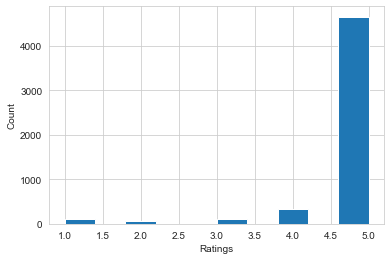

In [69]:
axarr = df.overall.hist()
axarr.set_xlabel("Ratings")
axarr.set_ylabel("Count")

In [70]:
df.shape

(5269, 20)

# Training models

In [71]:
nusers = df.userid.nunique()
nitems = df.itemid.nunique()

nusers, nitems

(991, 85)

In [72]:
for cat, le in style_encoders.items():
    print(f"{cat}, ncls: {len(le.classes_)}")

Size, ncls: 290
Flavor, ncls: 5
Color, ncls: 77
Scent Name, ncls: 9
Style Name, ncls: 5
Design, ncls: 22


In [73]:
X_train, X_test, y_train, y_test = train_test_split(df.drop("overall", axis=1), df.overall, random_state=999, test_size=0.1)

In [74]:
X_train.shape, X_test.shape

((4742, 19), (527, 19))

In [75]:
kf = KFold(n_splits=10, random_state=777)

C:\Users\fwojcik\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning:

Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.



In [76]:
for traini, testi in kf.split(X_train, y_train):
    X_train_cv, y_train_cv = X_train.iloc[traini], y_train.iloc[traini]
    X_test_cv, y_test_cv = X_train.iloc[testi], y_train.iloc[testi]
    print(X_train_cv.shape)
    print(X_test_cv.shape)
    break

(4267, 19)
(475, 19)


In [77]:
def MAPE(y_true, y_pred): 
    #y_true, y_pred = check_arrays(y_true, y_pred)

    ## Note: does not handle mix 1d representation
    #if _is_1d(y_true): 
    #    y_true, y_pred = _check_1d_array(y_true, y_pred)

    return np.mean(np.abs((y_true - y_pred) / y_true))

In [78]:
def train_model(model_builder, feature_builder_f, X_train, y_train, 
                X_test, y_test, kf, *args, **kwargs):
    mse_vals = []
    mae_vals = []
    mape_vals = []
    for traini, testi in tqdm(kf.split(X_train, y_train)):
        X_train_cv, y_train_cv = X_train.iloc[traini], y_train.iloc[traini]
        X_test_cv, y_test_cv = X_train.iloc[testi], y_train.iloc[testi]

        #print(f"CV train: {X_train_cv.shape}, test: {X_test_cv.shape}")

        model = model_builder()
        history = model.fit(feature_builder_f(X_train_cv), y_train_cv, epochs=10, *args, **kwargs)

        yhat_cv = model.predict(feature_builder_f(X_test_cv)).squeeze()
        mse, mae, mape = mean_squared_error(y_true=y_test_cv, y_pred=yhat_cv), mean_absolute_error(y_true=y_test_cv, y_pred=yhat_cv), MAPE(y_true=y_test_cv, y_pred=yhat_cv)
        mse_vals.append(mse)
        mae_vals.append(mae)
        mape_vals.append(mape)

    model_full = model_builder()
    full_hist = model_full.fit(feature_builder_f(X_train), y_train, *args, **kwargs)
    test_yhat = model_full.predict(feature_builder_f(X_test)).squeeze()
    test_mse, test_mae, test_mape = mean_squared_error(y_true=y_test, y_pred=test_yhat), mean_absolute_error(y_true=y_test, y_pred=test_yhat),  MAPE(y_true=y_test, y_pred=test_yhat)

    return mse_vals, mae_vals, mape_vals, test_mse, test_mae, test_mape, full_hist, model_full

In [79]:
def print_model_errors(model_name, mse, mae, mape, test_mse, test_mae, test_mape):
    print(f"""
    Model: {model_name}
    train MSE: {np.mean(mse)}
    train MAE: {np.mean(mae)}
    train MAPE: {np.mean(mape)}

    test MSE: {np.mean(test_mse)}
    test MAE: {np.mean(test_mae)}
    test MAPE: {np.mean(test_mape)}
    """)

## Collaborative filtering

In [80]:
def build_colabfilt():
    kk.backend.clear_session()
    gc.collect()

    uiembed_sz = 32

    uinput = kk.layers.Input(shape=(1,))
    uembed = kk.layers.Embedding(
        output_dim=uiembed_sz,
        input_dim=nusers+1,
        input_length=1,
        name='userembed')(uinput)
    uembed = kk.layers.Flatten()(uembed)
    ubias = kk.layers.Flatten()(kk.layers.Embedding(
        output_dim=1,
        input_dim=nusers,
        input_length=1,
        name='ubias')(uinput))

    iinput = kk.layers.Input(shape=(1,))
    iembed = kk.layers.Embedding(
        output_dim=uiembed_sz,
        input_dim=nitems+1,
        input_length=1,
        name='iembed')(iinput)
    iembed = kk.layers.Flatten()(iembed)
    ibias = kk.layers.Flatten()(kk.layers.Embedding(
        output_dim=1,
        input_dim=nitems+1,
        input_length=1,
        name='ibias')(iinput))

    ufull = kk.layers.add([uembed, ubias])
    ifull = kk.layers.add([iembed, ibias])
    out = kk.layers.Dot(axes=(1,1))([ifull, ufull])
    #out = kk.layers.add([dot, ubias, ibias])

    model_colab = kk.models.Model(inputs=[uinput, iinput], outputs=out)
    opt = kk.optimizers.Adam(lr=0.001)
    model_colab.compile(loss='mean_squared_error', optimizer=opt, metrics=['mse', 'mae', 'mape'])
    return model_colab

In [81]:
colab_feature_builder = lambda data: [data.userid, data.itemid]

In [72]:
colab_mse, colab_mae, colab_mape, colab_test_mse, colab_test_mae, colab_test_mape, colab_hist, colab_model = train_model(build_colabfilt, colab_feature_builder, X_train, y_train, X_test, y_test, kf, verbose=0, validation_split=0.1)

In [73]:
print_model_errors("colab", colab_mse, colab_mae, colab_mape, colab_test_mse, colab_test_mae, colab_test_mape)


    Model: colab
    train MSE: 0.8701976359643646
    train MAE: 0.3476181629182874
    train MAPE: 0.08218735328480872

    test MSE: 22.857315422868076
    test MAE: 4.7270519392276835
    test MAPE: 0.9867103607851144
    


## Deep matrix factorization

In [82]:
def build_deep_colabfilt():
    kk.backend.clear_session()
    gc.collect()

    uiembed_sz = 32

    uinput = kk.layers.Input(shape=(1,))
    uembed = kk.layers.Embedding(
        output_dim=uiembed_sz,
        input_dim=nusers+1,
        input_length=1,
        name='userembed', 
        embeddings_initializer=kk.initializers.he_normal())(uinput)
    uembed = kk.layers.Flatten()(uembed)
    ubias = kk.layers.Flatten()(kk.layers.Embedding(
        output_dim=1,
        input_dim=nusers,
        input_length=1,
        name='ubias')(uinput))

    iinput = kk.layers.Input(shape=(1,))
    iembed = kk.layers.Embedding(
        output_dim=uiembed_sz,
        input_dim=nitems+1,
        input_length=1,
        name='iembed',
        embeddings_initializer=kk.initializers.he_normal())(iinput)
    iembed = kk.layers.Flatten()(iembed)
    ibias = kk.layers.Flatten()(kk.layers.Embedding(
        output_dim=1,
        input_dim=nitems+1,
        input_length=1,
        name='ibias')(iinput))

    concat = kk.layers.Concatenate()([uembed, iembed, ubias, ibias])
    drop1 = kk.layers.Dropout(0.2)(concat)
    d1 = kk.layers.Dense(16, activation='tanh', kernel_regularizer=kk.regularizers.l2(0.001))(drop1)

    drop2 = kk.layers.Dropout(0.2)(d1)
    d2 = kk.layers.Dense(8, activation='tanh')(drop2)

    #drop3 = kk.layers.Dropout(0.2)(d1)
    out = kk.layers.Dense(1, activation='relu',  kernel_regularizer=kk.regularizers.l2(0.001))(d2)

    model_colab_deep = kk.models.Model(inputs=[uinput, iinput], outputs=out)
    opt = kk.optimizers.Adam(lr=0.01)
    model_colab_deep.compile(loss='mean_squared_error', optimizer=opt, metrics=['mse', 'mae', 'mape'])
    return model_colab_deep

In [83]:
deepcolabfilt_feature_builder = lambda data: [data.userid, data.itemid]

In [76]:
deepcolab_mse, deepcolab_mae, deepcolab_mape, deepcolab_test_mse, deepcolab_test_mae, deepcolab_test_mape, deepcolab_hist, deepcolab_model = train_model(build_deep_colabfilt, deepcolabfilt_feature_builder, X_train, y_train, X_test, y_test, kf, verbose=0, validation_split=0.1)

In [77]:
print_model_errors("deep colab", deepcolab_mse, deepcolab_mae, deepcolab_mape, deepcolab_test_mse, deepcolab_test_mae, deepcolab_test_mape)


    Model: deep colab
    train MSE: 0.12137566756044856
    train MAE: 0.10803681771537607
    train MAPE: 0.037663587470137226

    test MSE: 0.5302707811488842
    test MAE: 0.3592532737431535
    test MAPE: 0.13923411587233192
    


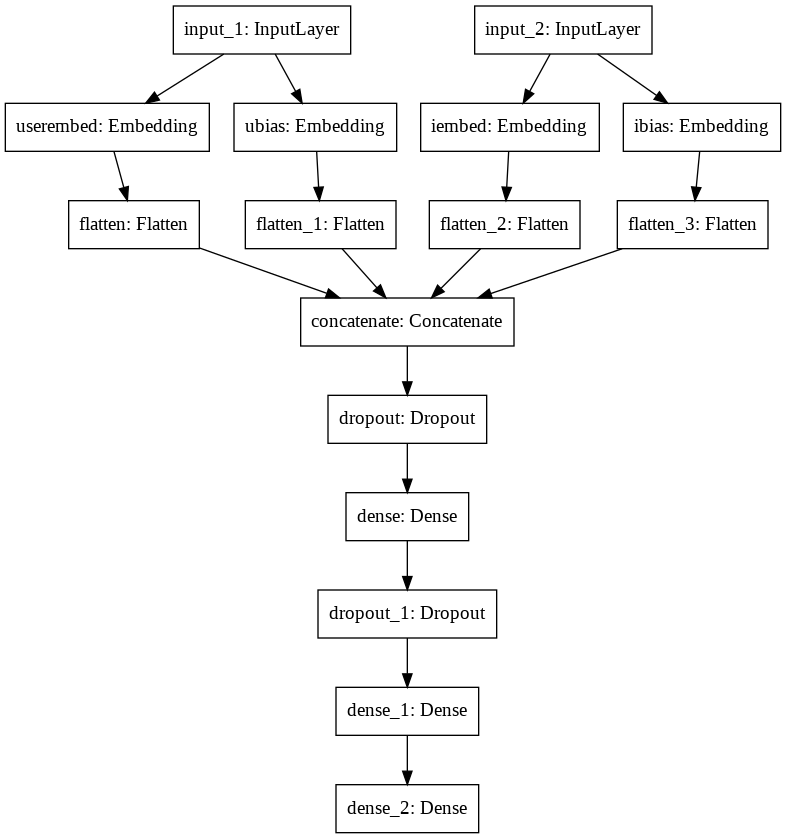

In [78]:
kk.utils.plot_model(deepcolab_model)

In [79]:
deepcolab_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
userembed (Embedding)           (None, 1, 32)        31744       input_1[0][0]                    
__________________________________________________________________________________________________
iembed (Embedding)              (None, 1, 32)        2752        input_2[0][0]                    
______________________________________________________________________________________________

## Content based model

In [84]:
for cat, le in style_encoders.items():
    print(f"{cat}, ncls: {len(le.classes_)}")

Size, ncls: 290
Flavor, ncls: 5
Color, ncls: 77
Scent Name, ncls: 9
Style Name, ncls: 5
Design, ncls: 22


In [85]:
def build_content_model():
    kk.backend.clear_session()
    gc.collect()

    size_embed_sz = 16
    col_embed_sz = 16
    design_embed_sz = 4
    flavor_embed_sz = 4
    style_name_embed_sz = 4
    scent_name_embed_sz = 8

    uiembed_sz = 32

    iinput = kk.layers.Input(shape=(1,))
    uinput = kk.layers.Input(shape=(1,))
    size_input = kk.layers.Input(shape=(1,))
    col_input = kk.layers.Input(shape=(1, ))
    design_input = kk.layers.Input(shape=(1,))
    flavor_input = kk.layers.Input(shape=(1,))
    style_input = kk.layers.Input(shape=(1,))
    scent_input = kk.layers.Input(shape=(1,))

    uembed = kk.layers.Embedding(
        output_dim=24,
        input_dim=nusers+1,
        input_length=1,
        name='userembed',
        #embeddings_initializer=kk.initializers.he_normal()
        )(uinput)
    uembed = kk.layers.Flatten()(uembed)
    ubias = kk.layers.Flatten()(kk.layers.Embedding(
        output_dim=1,
        input_dim=nusers,
        input_length=1,
        name='ubias')(uinput))

    iembed = kk.layers.Embedding(
        output_dim=16,
        input_dim=nitems+1,
        input_length=1,
        name='iembed',
        #embeddings_initializer=kk.initializers.he_normal()
        )(iinput)
    iembed = kk.layers.Flatten()(iembed)
    ibias = kk.layers.Flatten()(kk.layers.Embedding(
        output_dim=1,
        input_dim=nitems+1,
        input_length=1,
        name='ibias')(iinput))

    size_embed = kk.layers.Flatten()(kk.layers.Embedding(
        output_dim=size_embed_sz,
        input_dim=len(style_encoders['Size'].classes_) + 1,
        input_length=1,
        name="size_embed",
     #   embeddings_initializer=kk.initializers.he_normal()
    )(size_input))
    color_embed = kk.layers.Flatten()(kk.layers.Embedding(
        output_dim=col_embed_sz,
        input_dim=len(style_encoders['Color'].classes_) + 1,
        input_length=1,
        name="col_embed",
       # embeddings_initializer=kk.initializers.he_normal()
    )(col_input))
    design_embed = kk.layers.Flatten()(kk.layers.Embedding(
        output_dim=design_embed_sz,
        input_dim=len(style_encoders['Design'].classes_) + 1,
        input_length=1,
        name="design_embed",
       # embeddings_initializer=kk.initializers.he_normal()
    )(design_input))
    flavor_embed = kk.layers.Flatten()(kk.layers.Embedding(
        output_dim=flavor_embed_sz,
        input_dim=len(style_encoders['Flavor'].classes_) + 1,
        input_length=1,
        name="flavor_embed",
      #  embeddings_initializer=kk.initializers.he_normal()
    )(flavor_input))
    stylename_embed = kk.layers.Flatten()(kk.layers.Embedding(
        output_dim=style_name_embed_sz,
        input_dim=len(style_encoders['Style Name'].classes_) + 1,
        input_length=1,
        name="stylename_embed",
      #  embeddings_initializer=kk.initializers.he_normal()
    )(style_input))
    scent_embed = kk.layers.Flatten()(kk.layers.Embedding(
        output_dim=scent_name_embed_sz,
        input_dim=len(style_encoders['Scent Name'].classes_) + 1,
        input_length=1,
        name="scent_embed",
     #   embeddings_initializer=kk.initializers.he_normal()
    )(scent_input))

    # 25 units
    uall = kk.layers.Concatenate()([uembed, ubias])
    udrop = kk.layers.Dropout(0.1)(uall)
    udense = kk.layers.Dense(8, activation='tanh')(udrop)

    # 17 units
    iall = kk.layers.Concatenate()([iembed, ibias])
    idrop = kk.layers.Dropout(0.1)(iall)
    idense = kk.layers.Dense(8, activation='tanh')(idrop)

    # 16 + 4 + 4 = 24 units
    fall = kk.layers.Concatenate()([color_embed, stylename_embed, scent_embed]) #, color_embed, scent_embed])
    fdrop = kk.layers.Dropout(0.1)(fall)
    fdense = kk.layers.Dense(16, activation='tanh')(fdrop)

    # 24 + 25 + 17
    concat = kk.layers.Concatenate()([udense, idense, fdense])
    #dropall = kk.layers.Dropout(0.1)(concat)
    denseall = kk.layers.Dense(16, activation='tanh')(concat)
    #denseall2 = kk.layers.Dense(16, activation='tanh', kernel_regularizer=kk.regularizers.l2(0.001))(denseall)
    out = kk.layers.Dense(1, activation='relu')(denseall)
    """
    concat = kk.layers.Concatenate()([uembed, ubias, iembed, ibias, size_embed, stylename_embed, flavor_embed]) #, stylename_embed, flavor_embed])
    drop1 = kk.layers.Dropout(0.2)(concat)
    d1 = kk.layers.Dense(32, activation='tanh', kernel_regularizer=kk.regularizers.l2(0.001))(drop1)

    drop2 = kk.layers.Dropout(0.1)(d1)
    d2 = kk.layers.Dense(16, activation='tanh')(drop2)

    out = kk.layers.Dense(1, activation='relu')(d2)
    """
    
    model_content = kk.models.Model(inputs=[uinput, iinput, size_input, col_input, design_input, flavor_input, style_input, scent_input], outputs=out)
    opt = kk.optimizers.Adam(0.01)
    model_content.compile(loss='mean_squared_error', optimizer=opt, metrics=['mse', 'mae', 'mape'])
    return model_content

In [86]:
content_model_feature_builder = lambda data: [data.userid, data.itemid, data.Size, data.Color, data.Design, data.Flavor, data['Style Name'], data['Scent Name']]

In [94]:
es = kk.callbacks.EarlyStopping(monitor='mse', min_delta=0.005, patience=2)
content_mse, content_mae, content_mape, content_test_mse, content_test_mae, content_test_mape, conent_hist, content_model = train_model(build_content_model, content_model_feature_builder, X_train, y_train, X_test, y_test, kf, verbose=0, callbacks=[es])

In [96]:
print_model_errors("Content model", content_mse, content_mae, content_mape, content_test_mse, content_test_mae, content_test_mape)


    Model: Content model
    train MSE: 0.09583486656651453
    train MAE: 0.08693241182656625
    train MAPE: 0.02735752764008622

    test MSE: 0.16981348403016774
    test MAE: 0.16918544117820783
    test MAPE: 0.06523918938139128
    


----------------------------

In [ ]:
# uembed: 24  (user dense: 8 - item dense: 8 - features dense: 16) - (dense: 16 - 1) no dropout on dense, no regularization
print_model_errors("Content model", content_mse, content_mae, content_mape, content_test_mse, content_test_mae, content_test_mape)


    Model: Content model
    train MSE: 0.09300321332403756
    train MAE: 0.08373591233109888
    train MAPE: 0.02883052729803167

    test MSE: 0.21010976081888158
    test MAE: 0.15495792195285746
    test MAPE: 0.07630318119735532
    


In [85]:
print_model_errors("deep colab", deepcolab_mse, deepcolab_mae, deepcolab_mape, deepcolab_test_mse, deepcolab_test_mae, deepcolab_test_mape)


    Model: deep colab
    train MSE: 0.12137566756044856
    train MAE: 0.10803681771537607
    train MAPE: 0.037663587470137226

    test MSE: 0.5302707811488842
    test MAE: 0.3592532737431535
    test MAPE: 0.13923411587233192
    


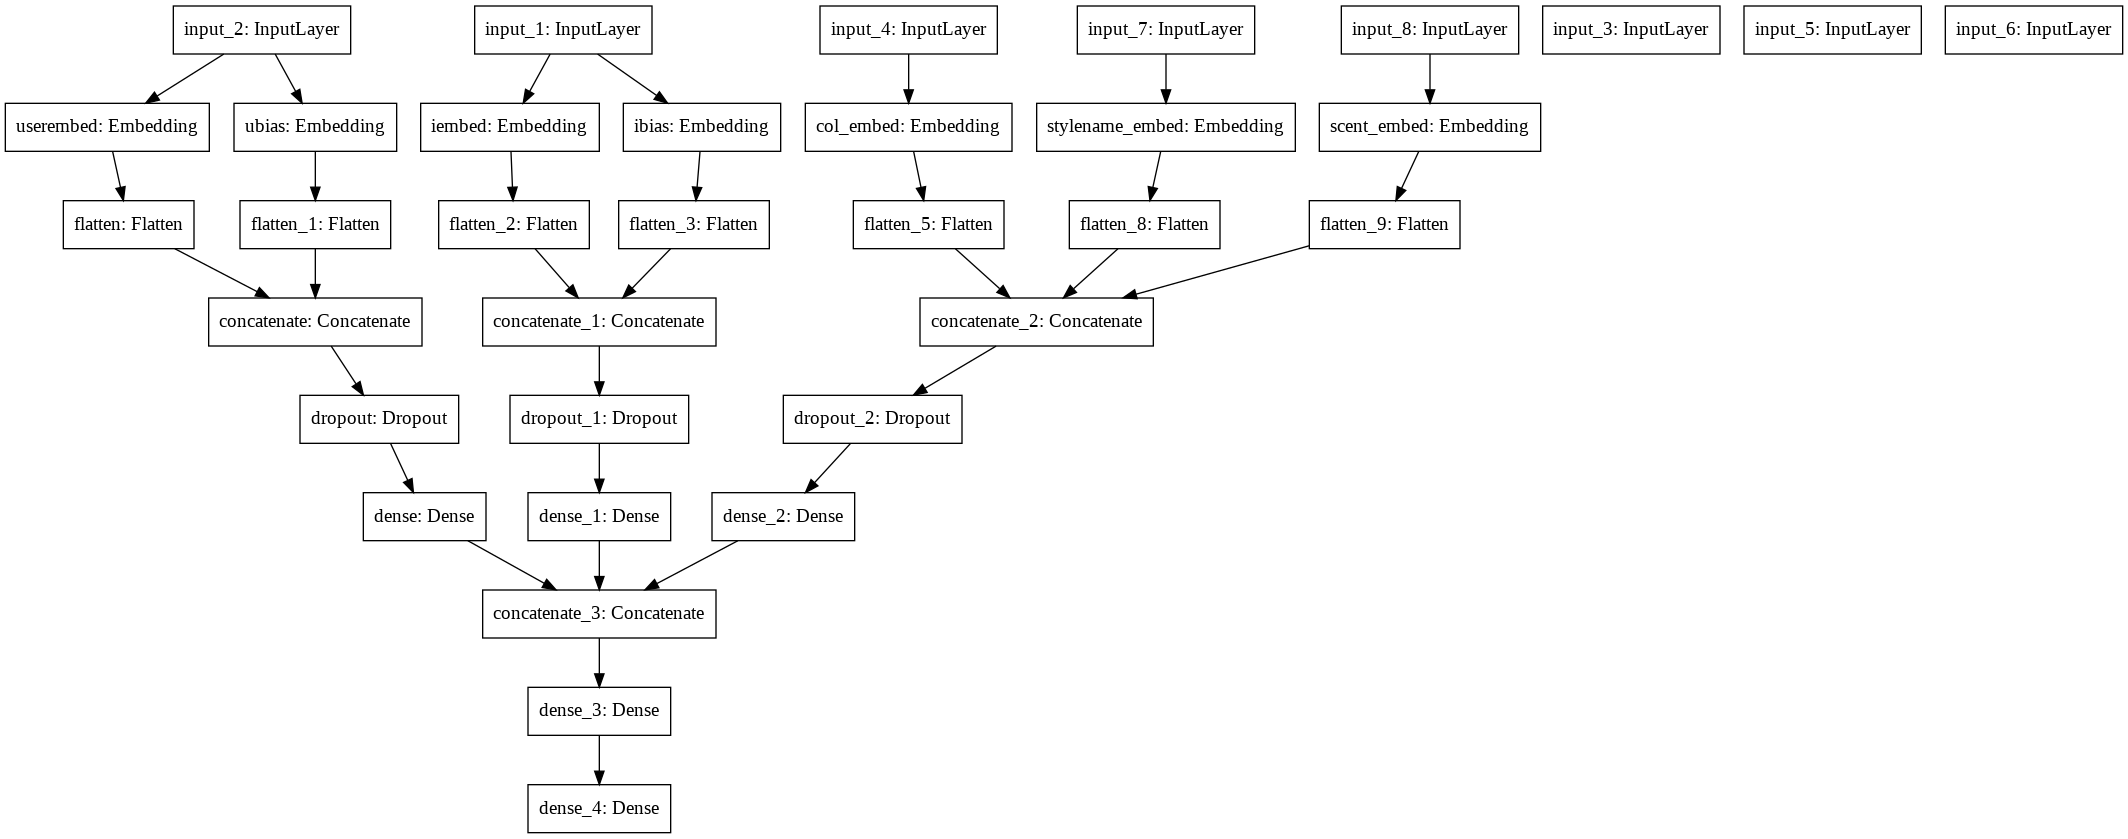

In [ ]:
kk.utils.plot_model(content_model)

In [ ]:
content_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 1)]          0                                            
______________________________________________________________________________________________

## Test data predictions

In [37]:
colab_model = kk.models.load_model("../models/colab_model")
content_model = kk.models.load_model("../models/conent_model")
deepcolab_model = kk.models.load_model("../models/deep_colab_model")

In [44]:
np.expand_dims(v1.to_numpy(), -1).shape

(527, 1)

In [47]:
v1, v2 = colab_feature_builder(X_test)
opt = kk.optimizers.Adam(lr=0.001)
colab_model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mse', 'mae', 'mape'])
yhat_test_colab = colab_model.predict([np.expand_dims(v1.to_numpy(dtype=np.int32), -1), np.expand_dims(v2.to_numpy(dtype=np.int32), -1)])

ValueError: invalid literal for int() with base 10: 'class_name'

# Save model results

In [97]:
train_mae = pd.DataFrame({
    'content': content_mae,
    'deep_colab': deepcolab_mae,
    'colab': colab_mae
})
train_mse = pd.DataFrame({
    'content': content_mse,
    'deep_colab': deepcolab_mse,
    'colab': colab_mse
})
train_mape = pd.DataFrame({
    'content': content_mape,
    'deep_colab': deepcolab_mape,
    'colab': colab_mape
})

test_data_res = pd.DataFrame({
    'colab': [colab_test_mae, colab_test_mape, colab_test_mse],
    'deep_colab': [deepcolab_test_mae, deepcolab_test_mape, deepcolab_test_mse],
    'content': [content_test_mae, content_test_mape, content_test_mse]
}, index=['test_mae', 'test_mape', 'test_mse'])


In [98]:
train_mae.to_csv("train_mae_res.csv", index=False)
train_mse.to_csv("train_mse_res.csv", index=False)
train_mape.to_csv("train_mape_res.csv", index=False)

test_data_res.to_csv("test_data_res.csv", index=True)

In [4]:
train_mae = pd.read_csv("../reports/train_mae_res.csv", index_col=None)
train_mse = pd.read_csv("../reports/train_mse_res.csv",  index_col=None)
train_mape = pd.read_csv("../reports/train_mape_res.csv",  index_col=None)

test_data_res = pd.read_csv("../reports/test_data_res.csv", index_col=0)

In [99]:
colab_model.save("./colab_model")
content_model.save("./conent_model")
deepcolab_model.save("./deep_colab_model")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./colab_model/assets
INFO:tensorflow:Assets written to: ./conent_model/assets
INFO:tensorflow:Assets written to: ./deep_colab_model/assets


In [100]:
!zip -r ./colab_model.zip ./colab_model/

  adding: colab_model/ (stored 0%)
  adding: colab_model/saved_model.pb (deflated 89%)
  adding: colab_model/variables/ (stored 0%)
  adding: colab_model/variables/variables.index (deflated 63%)
  adding: colab_model/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: colab_model/assets/ (stored 0%)


In [101]:
!zip -r ./content_model.zip ./conent_model/

  adding: conent_model/ (stored 0%)
  adding: conent_model/saved_model.pb (deflated 90%)
  adding: conent_model/variables/ (stored 0%)
  adding: conent_model/variables/variables.index (deflated 70%)
  adding: conent_model/variables/variables.data-00000-of-00001 (deflated 9%)
  adding: conent_model/assets/ (stored 0%)


In [102]:
!zip -r ./deep_colab_model.zip ./deep_colab_model/

  adding: deep_colab_model/ (stored 0%)
  adding: deep_colab_model/saved_model.pb (deflated 90%)
  adding: deep_colab_model/variables/ (stored 0%)
  adding: deep_colab_model/variables/variables.index (deflated 67%)
  adding: deep_colab_model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: deep_colab_model/assets/ (stored 0%)


# Statistical comparisons

In [7]:
train_mae.describe()

,content,deep_colab,colab
count,10.000000,10.000000,10.000000
mean,0.086932,0.108037,0.347618
std,0.013374,0.016036,0.077915
min,0.071966,0.082395,0.229990
25%,0.077140,0.096528,0.302102
50%,0.082345,0.109263,0.336365
75%,0.100326,0.120567,0.402659
max,0.105977,0.131735,0.487377


In [8]:
train_mape.describe()

,content,deep_colab,colab
count,10.000000,10.000000,10.000000
mean,0.027358,0.037664,0.082187
std,0.006914,0.007112,0.018024
min,0.018393,0.022453,0.056065
25%,0.022683,0.034671,0.073383
50%,0.024775,0.037409,0.077206
75%,0.033288,0.042545,0.093773
max,0.039227,0.046571,0.116838


In [9]:
train_mse.describe()

,content,deep_colab,colab
count,10.000000,10.000000,10.000000
mean,0.095835,0.121376,0.870198
std,0.036194,0.026243,0.405272
min,0.048836,0.081004,0.367964
25%,0.068130,0.106168,0.658509
50%,0.093216,0.121486,0.772182
75%,0.117481,0.139986,0.947518
max,0.160067,0.157365,1.708260


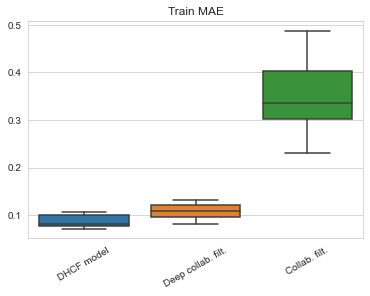

In [37]:
mae_fig =sns.boxplot(x=['DHCF model', 'Deep collab. filt.', 'Collab. filt.'], y=[train_mae.content, train_mae.deep_colab, train_mae.colab]);
mae_fig.set_xticklabels(mae_fig.get_xticklabels(), rotation=30);
mae_fig.set_title("Train MAE");

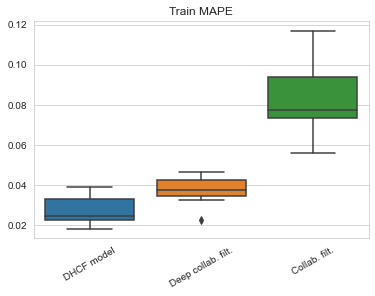

In [38]:
mape_fig =sns.boxplot(x=['DHCF model', 'Deep collab. filt.', 'Collab. filt.'], y=[train_mape.content, train_mape.deep_colab, train_mape.colab]);
mape_fig.set_xticklabels(mape_fig.get_xticklabels(), rotation=30);
mape_fig.set_title("Train MAPE");

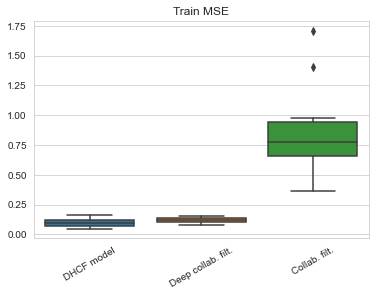

In [39]:
mse_fig =sns.boxplot(x=['DHCF model', 'Deep collab. filt.', 'Collab. filt.'], y=[train_mse.content, train_mse.deep_colab, train_mse.colab]);
mse_fig.set_xticklabels(mse_fig.get_xticklabels(), rotation=30);
mse_fig.set_title("Train MSE");

Grouped plots

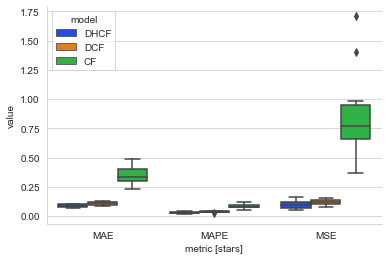

In [8]:
train_mae_melt = train_mae.melt(var_name='model')
train_mae_melt['metric'] = 'MAE'

train_mape_melt = train_mape.melt(var_name='model')
train_mape_melt['metric'] = 'MAPE'

train_mse_melt = train_mse.melt(var_name='model')
train_mse_melt['metric'] = 'MSE'

train_metrics = train_mae_melt.append(train_mape_melt, ignore_index=True).append(train_mse_melt, ignore_index=True)
#px.box(train_metrics, x='metric', y='value', color='model', template='plotly_white', labels='model', )
train_metrics.model.replace({
    'colab': "CF",
    'deep_colab': 'DCF',
    'content': "DHCF"
}, inplace=True)
f = plt.figure()
boxplt = sns.boxplot(x="metric", y="value",
            palette="bright",
            hue="model",
            data=train_metrics)
sns.despine(trim=False)
boxplt.set(xlabel='metric [stars]')
f.savefig('boxlot.svg', format='svg')

In [25]:
test_data_res

,colab,deep_colab,content
test_mae,4.727052,0.359253,0.169185
test_mape,0.986710,0.139234,0.065239
test_mse,22.857315,0.530271,0.169813


In [31]:
st.friedmanchisquare(train_mse.content, train_mse.deep_colab, train_mse.colab)

FriedmanchisquareResult(statistic=18.200000000000017, pvalue=0.0001116658084901137)

In [33]:
st.friedmanchisquare(train_mae.content, train_mae.deep_colab, train_mae.colab)

FriedmanchisquareResult(statistic=20.0, pvalue=4.539992976248486e-05)

In [34]:
st.friedmanchisquare(train_mape.content, train_mape.deep_colab, train_mape.colab)

FriedmanchisquareResult(statistic=20.0, pvalue=4.539992976248486e-05)

In [36]:
sp.posthoc_conover([train_mae.content, train_mae.deep_colab, train_mae.colab], p_adjust='holm')

,1,2,3
1,-1.000000e+00,0.003570,3.257647e-09
2,3.570100e-03,-1.000000,5.727498e-06
3,3.257647e-09,0.000006,-1.000000e+00


In [41]:
sp.posthoc_conover([train_mse.content, train_mse.deep_colab, train_mse.colab], p_adjust='holm')

,1,2,3
1,-1.000000e+00,0.055181,6.024843e-08
2,5.518052e-02,-1.000000,6.626016e-06
3,6.024843e-08,0.000007,-1.000000e+00


In [42]:
sp.posthoc_conover([train_mape.content, train_mape.deep_colab, train_mape.colab], p_adjust='holm')

,1,2,3
1,-1.000000e+00,0.002509,2.265006e-09
2,2.509331e-03,-1.000000,5.413948e-06
3,2.265006e-09,0.000005,-1.000000e+00


### Test residual analysis

In [100]:
content_model = kk.models.load_model("../models/conent_model/")
colab_model = kk.models.load_model("../models/colab_model/")
deepcolab_model = kk.models.load_model("../models/deep_colab_model//")

In [101]:
content_model.compile(optimizer=kk.optimizers.Adam(), loss='mse')
colab_model.compile(optimizer=kk.optimizers.Adam(), loss='mse')
deepcolab_model.compile(optimizer=kk.optimizers.Adam(), loss='mse')

In [104]:
content_test_pred = content_model.predict(content_model_feature_builder(X_test)).squeeze()
deepcolab_test_pred = deepcolab_model.predict(deepcolabfilt_feature_builder(X_test)).squeeze()
colab_test_pred = colab_model.predict(colab_feature_builder(X_test)).squeeze()

In [116]:
content_mse_resid = (y_test - content_test_pred)**2
deepcolab_mse_resid = (y_test - deepcolab_test_pred) ** 2
colab_mse_resid = (y_test - colab_test_pred) ** 2

In [117]:
content_mae_resid = np.abs(y_test - content_test_pred)
deepcolab_mae_resid = np.abs(y_test - deepcolab_test_pred)
colab_mae_resid = np.abs(y_test - colab_test_pred)

In [118]:
content_mape_resid = content_mae_resid / y_test
deepcolab_mape_resid = deepcolab_mae_resid / y_test
colab_mape_resid = colab_mae_resid / y_test

In [137]:
resid_df = pd.DataFrame.from_records(
    list(zip(cycle(['mse']),  cycle(['DHCF']), content_mse_resid.to_list())) +
    list(zip(cycle(['mse']),  cycle(['DCF']), deepcolab_mse_resid.to_list())) + 
    list(zip(cycle(['mse']),  cycle(['CF']), colab_mse_resid.to_list())) + 
    list(zip(cycle(['mae']),  cycle(['DHCF']), content_mae_resid.to_list())) +
    list(zip(cycle(['mae']),  cycle(['DCF']), deepcolab_mae_resid.to_list())) + 
    list(zip(cycle(['mae']),  cycle(['CF']), colab_mae_resid.to_list())) +
    list(zip(cycle(['mape']), cycle(['DHCF']), content_mape_resid.to_list())) +
    list(zip(cycle(['mape']), cycle(['DCF']), deepcolab_mape_resid.to_list())) + 
    list(zip(cycle(['mape']), cycle(['CF']), colab_mape_resid.to_list())), columns=['metric', 'model', 'value'])
resid_df.head(3)

,metric,model,value
0,mse,DHCF,0.001392
1,mse,DHCF,0.000763
2,mse,DHCF,0.000047


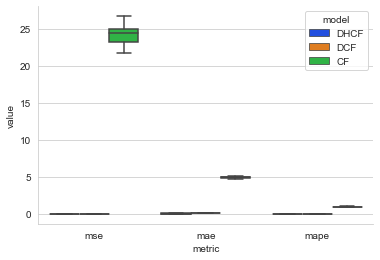

In [144]:
f = plt.figure()
ax = sns.boxplot(x="metric", y="value",
            palette="bright",
            hue="model",
            data=resid_df, showfliers = False)
#ax.set(yscale="log")
sns.despine(trim=False)
f.savefig('boxlot_test.svg', format='svg')

In [129]:


list(zip(cycle(['a', 'b']), [1,2,3]))

[('a', 1), ('b', 2), ('a', 3)]